# Аналитика коммуникаций в чатах Яндекс.Практикума
###Ход исследования

<p><b>Цель исследования — проанализировать активность в чатах Слака, выяснить, когда активность студентов в чатах наибольшая и когда лучше публиковать анонсы, чтобы получить побольше откликов.</b>

###Задачи исследования:

Проанализировать различные типы каналов, когорт, групп; оценить в каких общения больше, в каких меньше, и как они различаются от когорты к когорте, от канала к каналу.
Проанализировать поведение студентов в чатах; выявить паттерны, динамику, цикличность в течение дня, недели, месяца, года; визуализировать свои находки.
Понять, когда активность студентов в чатах наибольшая, и когда лучше публиковать посты/анонсы, чтобы получить больше откликов.

In [ ]:
# импорт библиотек
import pandas as pd
import numpy as np
import warnings
import datetime
import re 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
# Сброс ограничений на число столбцов
#pd.set_option('display.max_columns', None)


In [ ]:
# вывод первых 5 записей
data.head()

,Unnamed: 0,client_msg_id,type,user,ts,latest_reply,team,thread_ts,subtype,channel,file_date,attachments,reactions,text_len,text_words
0,0,ae31e785-257b-4290-a4c6-9721337f67ea,message,U03JYMWQLP5,1.669643e+09,1.669645e+09,TPV9DP0N4,1.669643e+09,NaN,data-analysts-bus,2022-11-28,0,NaN,297,47
1,1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,message,U03V483FRKM,1.669645e+09,NaN,TPV9DP0N4,1.669643e+09,NaN,data-analysts-bus,2022-11-28,0,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'count': 1}]",434,63
2,2,NaN,message,U02KVQJHQ5S,1.669647e+09,NaN,NaN,NaN,channel_join,data-analysts-bus,2022-11-28,0,NaN,37,5
3,3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,message,U03JYMWQLP5,1.669709e+09,1.669719e+09,NaN,1.669709e+09,NaN,data-analysts-bus,2022-11-29,0,"[{'name': 'cat-high-five', 'users': ['U040E2D6CF2'], 'count': 1}]",69,12
4,4,b5e3413b-8f04-4192-948b-2423eb3192b2,message,U040E2D6CF2,1.669711e+09,NaN,TPV9DP0N4,1.669709e+09,NaN,data-analysts-bus,2022-11-29,0,NaN,19,2


In [ ]:
# вывод информации о столбцах
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26533 entries, 0 to 26532
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     26533 non-null  int64  
 1   client_msg_id  18262 non-null  object 
 2   type           26533 non-null  object 
 3   user           23643 non-null  object 
 4   ts             26533 non-null  float64
 5   latest_reply   2303 non-null   float64
 6   team           15857 non-null  object 
 7   thread_ts      18222 non-null  float64
 8   subtype        8317 non-null   object 
 9   channel        26533 non-null  object 
 10  file_date      26533 non-null  object 
 11  attachments    26533 non-null  int64  
 12  reactions      4169 non-null   object 
 13  text_len       26533 non-null  int64  
 14  text_words     26533 non-null  int64  
dtypes: float64(3), int64(4), object(8)
memory usage: 3.0+ MB


# Предобработка данных

In [ ]:
#первоначальный размер датафрейма
len(data)

26533

In [ ]:
# удаление первого столбца
del data[data.columns [0]]

In [ ]:
# преобразование данных о времени
data['ts'] = pd.to_datetime(data['ts'], unit='s')
data['ts'] = pd.to_datetime(data['ts'], format = "%Y%m%d").dt.strftime('%Y-%m-%d, %H:%M:%S') 

data['latest_reply'] = pd.to_datetime(data['latest_reply'], unit='s')
data['latest_reply'] = pd.to_datetime(data['latest_reply'], format = "%Y%m%d").dt.strftime('%Y-%m-%d, %H:%M:%S') 

data['thread_ts'] = pd.to_datetime(data['thread_ts'], unit='s')
data['thread_ts'] = pd.to_datetime(data['thread_ts'], format = "%Y%m%d").dt.strftime('%Y-%m-%d, %H:%M:%S') 


In [ ]:
data.head()

,client_msg_id,type,user,ts,latest_reply,team,thread_ts,subtype,channel,file_date,attachments,reactions,text_len,text_words
0,ae31e785-257b-4290-a4c6-9721337f67ea,message,U03JYMWQLP5,"2022-11-28, 13:49:23","2022-11-28, 14:24:08",TPV9DP0N4,"2022-11-28, 13:49:23",NaN,data-analysts-bus,2022-11-28,0,NaN,297,47
1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,message,U03V483FRKM,"2022-11-28, 14:24:08",NaN,TPV9DP0N4,"2022-11-28, 13:49:23",NaN,data-analysts-bus,2022-11-28,0,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'count': 1}]",434,63
2,NaN,message,U02KVQJHQ5S,"2022-11-28, 14:48:50",NaN,NaN,NaN,channel_join,data-analysts-bus,2022-11-28,0,NaN,37,5
3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,message,U03JYMWQLP5,"2022-11-29, 08:08:12","2022-11-29, 10:56:57",NaN,"2022-11-29, 08:08:12",NaN,data-analysts-bus,2022-11-29,0,"[{'name': 'cat-high-five', 'users': ['U040E2D6CF2'], 'count': 1}]",69,12
4,b5e3413b-8f04-4192-948b-2423eb3192b2,message,U040E2D6CF2,"2022-11-29, 08:32:32",NaN,TPV9DP0N4,"2022-11-29, 08:08:12",NaN,data-analysts-bus,2022-11-29,0,NaN,19,2


In [ ]:
# проверка на дубликаты
data.duplicated().value_counts()

False    26181
True       352
dtype: int64

In [ ]:
# удаление дубликатов
data = data.drop_duplicates ()

In [ ]:
data.duplicated().value_counts()

False    26181
dtype: int64

In [ ]:
# проверка на неявные дубликаты в столбце type
data['type'].value_counts()

message    26181
Name: type, dtype: int64

В столбце type находится только одно значение - message, пропущенных значений нет

In [ ]:
# проверка на неявные дубликаты в столбце team
data['team'].value_counts()

TPV9DP0N4    15857
Name: team, dtype: int64

In [ ]:
# количетсво пропущенных значений
data['team'].isnull().sum()

10324

В столбце team только два значения: либо Nan, либо "TPV9DP0N4". Заменим nan значения на 0



In [ ]:
data['team'] = data['team'].fillna(0)

In [ ]:
# проверка на неявные дубликаты в столбце subtype
data['subtype'].value_counts()

channel_leave        3265
bot_message          2538
channel_join         2026
thread_broadcast      108
tombstone              14
channel_unarchive      10
channel_purpose         2
bot_remove              1
channel_name            1
Name: subtype, dtype: int64

В столбце subtype можно увидеть такие метки пользователей:
- channel_leave  - сообщение "покинул канал"
- bot_message - сообщение от бота
- channel_join - сообщение "присоединился к каналу"
- thread_broadcast - сообщение должно транслироваться на весь канал
- tombstone - файлы, превышающие лимит, отображаться как «захороненные» с отредактированной информацией и полем «hidden_by_limit»
- channel_unarchive - сообщение отправляется всем соединениям для рабочей области, когда канал разархивирован
- channel_purpose - ?
- bot_remove - удаление бота
- channel_name - сообщение о названии канала


In [ ]:
# количество пропущенных значений
data['subtype'].isnull().sum()/ len(data['subtype']) * 100

69.57717428669646

Почти 70% сообщений не содержат метки. Поскольку стоит задача проанализировать именно поведение пользователей, все сообщения со служебными метками удалим

In [ ]:
data = data.query('subtype!=subtype')

In [ ]:
# проверка на неявные дубликаты в столбце channel
data['channel'].value_counts()

ds_55_projects_1             440
ds_46_exerciser              435
ds_57_teamwork               392
da_60_projects_02            389
da_plus_18_teamwork          366
                            ... 
de_28_digital_professions      1
de_28_group_green              1
da_plus_16_mentors             1
da_plus_16_exerciser           1
de_23_projects                 1
Name: channel, Length: 372, dtype: int64

В данном списке представлены все названия каналов, в дальнейшем можно будет рассмотреть их популярность и сгруппировать в когорты

In [ ]:
# количество пропущенных значений в столбце channel
data['channel'].isnull().sum()/ len(data['channel']) * 100

0.0

В столбце channel пропусков нет

In [ ]:
# количество пропущенных значений в столбце file_date
data['file_date'].isnull().sum()/ len(data['file_date']) * 100

0.0

В столбце file_date пропусков нет

In [ ]:
# проверка значений в столбце attachments
data['attachments'].value_counts()

0    18000
1      188
2       19
3        7
4        1
5        1
Name: attachments, dtype: int64

In [ ]:
# количество пропущенных значений в столбце attachments
data['attachments'].isnull().sum()/ len(data['attachments']) * 100

0.0

В столбце attachments отображено количество загружаемых файлов. Таким образом, постов с
- 0 файлов - 18000
- 1 файлом - 188
- 2 файлами - 19
- 3 файлами - 7
- 4 файлами - 1
- 5 файлами - 1
Пропущенных значений нет


In [ ]:
# количество пропущенных значений в столбце reactions
data['reactions'].isnull().sum()/ len(data['reactions']) * 100

77.66798418972331

Столбец reactions содержит списки словарей, имеющих структуру {'name': 'cat-high-five', 'users': ['U0421JZP400', 'U02Q4P6SGBC'], 'count': 2}, в которых хранится название реакции, список пользвателей, которые ее поставили и количество.
Можно найти посты с наибольшим количеством реакций (от кого, в какое время). Можно найти самого активного пользователя и тех, кто никогда реакцию не оставляет.
В целом, 77.7% постов не имеют никаких реакций

In [ ]:
# количество пропущенных значений в столбце text_len
data['text_len'].isnull().sum()/ len(data['text_len']) * 100

0.0

In [ ]:
# количество пропущенных значений в столбце text_words
data['text_words'].isnull().sum()/ len(data['text_words']) * 100

0.0

Столбцы, хранящие информацию о длине сообщения и количестве слов в сообщении, пропусков не имеют

In [ ]:
# проверим пропуски в столбце client_msg_id
data['client_msg_id'].isnull().sum()

62

In [ ]:
nan_client_msg_id = data.query('client_msg_id != client_msg_id')
nan_client_msg_id 

,client_msg_id,type,user,ts,latest_reply,team,thread_ts,subtype,channel,file_date,attachments,reactions,text_len,text_words
197,NaN,message,U01QMDLG9AP,"2022-12-13, 14:06:03","2022-12-13, 14:19:00",TPV9DP0N4,"2022-12-13, 14:06:03",NaN,data_edteam_info,2022-12-13,1,NaN,208,30
2064,NaN,message,U0203TTA1AQ,"2022-11-27, 16:19:18","2022-12-11, 08:57:05",TPV9DP0N4,"2022-11-27, 16:19:18",NaN,da_55_projects,2022-11-27,0,NaN,227,36
2065,NaN,message,U0203TTA1AQ,"2022-11-27, 16:19:18",NaN,TPV9DP0N4,NaN,NaN,da_55_projects,2022-11-27,0,NaN,182,30
2066,NaN,message,U0203TTA1AQ,"2022-11-27, 16:19:18","2022-12-07, 20:01:33",TPV9DP0N4,"2022-11-27, 16:19:18",NaN,da_55_projects,2022-11-27,0,NaN,522,82
2067,NaN,message,U0203TTA1AQ,"2022-11-27, 16:19:18","2022-12-05, 15:29:32",TPV9DP0N4,"2022-11-27, 16:19:18",NaN,da_55_projects,2022-11-27,0,NaN,207,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18174,NaN,message,U0203TTA1AQ,"2022-11-27, 15:58:49",NaN,TPV9DP0N4,NaN,NaN,ds_49_projects,2022-11-27,0,NaN,255,32
18175,NaN,message,U0203TTA1AQ,"2022-11-27, 15:58:49","2022-12-10, 20:28:09",TPV9DP0N4,"2022-11-27, 15:58:49",NaN,ds_49_projects,2022-11-27,0,NaN,66,9
23639,NaN,message,U04ABUPLS83,"2022-12-12, 09:31:44",NaN,TPV9DP0N4,NaN,NaN,ds_58_teamwork,2022-12-12,1,NaN,14,1
25971,NaN,message,U0431FHJFV5,"2022-12-01, 14:33:17",NaN,TPV9DP0N4,NaN,NaN,ds_plus_18_teamwork,2022-12-01,1,NaN,0,0


In [ ]:
nan_client_msg_id['team'].value_counts()

TPV9DP0N4    62
Name: team, dtype: int64

In [ ]:
nan_client_msg_id['reactions'].value_counts()

[{'name': 'heavy_check_mark', 'users': ['USWN6S8V6'], 'count': 1}]    1
Name: reactions, dtype: int64

В столбце client_msg_id есть 62 пропуска. Если рассмотреть данные с пропусками детально, можно заметить, что все эти сообщения от группы TPV9DP0N4 (вероятно, являющимися командой Практикума). Возможно, это удаленные посты. Уберем их из данных

In [ ]:
data = data.query('client_msg_id == client_msg_id')

In [ ]:
# проверка числовых данных на аномалии

#проверка столбца длина текста
data['text_len'].describe()

count    18154.000000
mean       199.838383
std        278.936978
min          0.000000
25%         57.000000
50%        120.000000
75%        241.000000
max      10933.000000
Name: text_len, dtype: float64

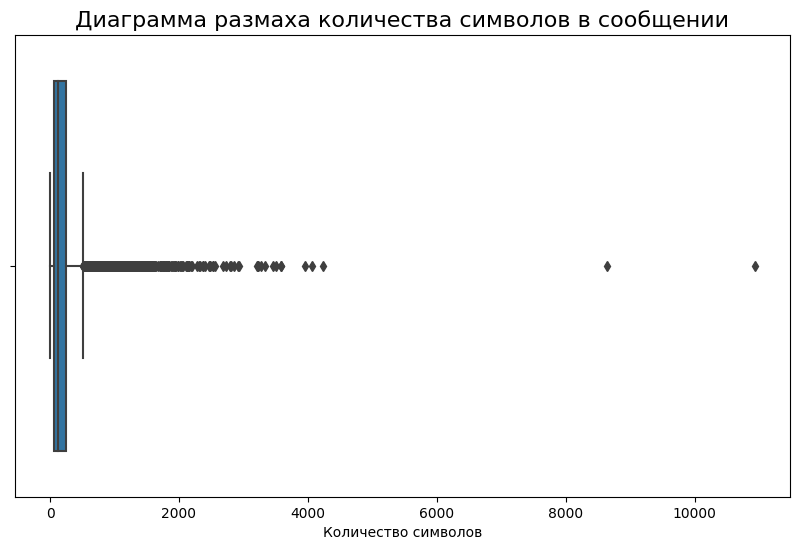

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x=data['text_len'])
plt.xlabel("Количество символов")
plt.title("Диаграмма размаха количества символов в сообщении", size=16)
plt.show()

Видно, что в столбце text_len присутствуют аномалии - очень длинные сообщения. 
75% сообщений не превышает 241 знака, так же имеются сообщения с 0 знаков.
Рассмотрим все это подробнее

Очень длинные сообщения удалять из данных не будем, возможно, имел место фрагмент кода - это увеличило и само сообщение, и количество слов в нём

In [ ]:
#проверка столбца количество слов в сообщении
data['text_words'].describe()

count    18154.000000
mean        26.622397
std         35.417209
min          0.000000
25%          7.000000
50%         16.000000
75%         33.000000
max        989.000000
Name: text_words, dtype: float64

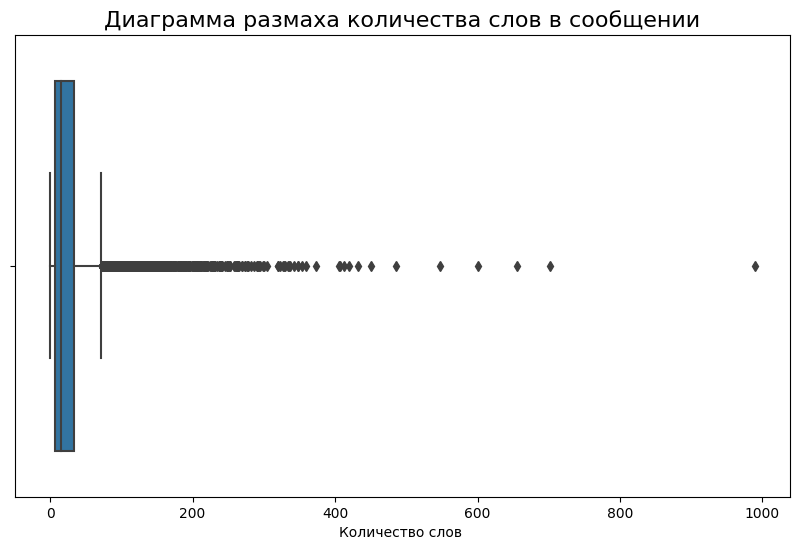

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x=data['text_words'])
plt.xlabel("Количество слов ")
plt.title("Диаграмма размаха количества слов в сообщении", size=16)
plt.show()

75% сообщений содержат не более 33 слов, также присутствуют аномально длинные сообщения и пустые сообщения

In [ ]:
len(data)

18154

## Вывод по разделу:
- Начальный размер датафрейма 26533
- Обнаружено 352 дубликата
- 70% сообщений не содержат служебные метки, остальные сообщения с метками были удалены
- В столбце client_msg_id есть 62 nan-значения, возможно, удаленные сообщения; эти строки удалены из датафрейма
- Столбцы длина текста и количество слов содержат аномальные значения - пустые сообщения и очень длинные сообщения. С этими строками ничего делать не будем
- Размер конечного датафрейма 18154, что составило 68% исходного - считаю, этих данных достаточно для анализа реакций пользователей на сообщения в рамках оценки поведения пользователей


# Создание дополнительных столбцов

In [ ]:
# создание столбца с краткой датой
data['ts_date'] = pd.to_datetime(data['ts']).dt.date
# создание столбца Год
data['ts_year'] = pd.to_datetime(data['ts']).dt.year
# создание столбца Месяц
data['ts_month'] = pd.to_datetime(data['ts']).dt.month
# создание столбца День недели
data['ts_day'] = pd.to_datetime(data['ts']).dt.day_name()
# создание столбца Время
data['ts_time'] = pd.to_datetime(data['ts']).dt.time
# преобразование только в часы
data['ts_time'] = pd.to_datetime(data['ts_time'], format='%H:%M:%S').dt.hour

In [ ]:
# замена неявных дубликатов
data['chogort_name'] = data['chogort_name'].str.replace('11dа_plus', 'da_plus_11')
data['chogort_name'] = data['chogort_name'].str.replace('12ds_plus', 'ds_plus_12')
data['chogort_name'] = data['chogort_name'].str.replace('9ds_plus', 'ds_plus_09')

## Вывод по разделу:
- созданы дополнительные столбцы
- созданы функции, для извлечения канала, номера когорты, направления обучения, подсчета количества реакций

# Анализ

* Гипотеза 1. "Зависимость количества реакций от дня недели и времени суток"
* Гипотеза 2. "Зависимость количества реакций от автора сообщения из команды Практикума"
* Гипотеза 3. "Зависимость количества реакций от длины сообщения"
* Гипотеза 4. "Больше реакций получают сообщения участников команды Яндекс.Практикума"

## Сообщения и реакции (общее)

### Количество сообщений и реакций по датам

In [ ]:
# график распределения сообщени и реакций по датам
df = post_and_react
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от даты')
fig.update_layout(
    xaxis_title="Дата",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()


С 28 ноября наблюдается скачок в количестве сообщений и реакций, возможно, в это время заканчивался один спринт и начинался другой - у студентов были вопросы, которые нужно было срочно решать.
Анализируя график, можно заметить, что количество реакций всегда меньше или равно количествую сообщений, кроме трех случаев:
- 25.11.2022: 24 сообщения и 77 реакций
- 28.11.2022: 1391 сообщение и 1473 реакции
- 15.12.2022: 217 сообщений и 556 реакций

Основная активность наблюдается с 28.11 по 17.12, что соответствует вероятному времени спринта (почти ровно три недели с понедельника по субботу)

### Сообщения и реакции по дням недели

In [ ]:
# график распределения сообщени и реакций по датам
df = post_and_react
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от дня недели')
fig.update_layout(
    xaxis_title="День недели",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()


Анализируя график, можно отметить, что количество постов и реакций в целом совпадают по появлению: больше всего постов и реакций в понедельник и среду, меньше всего - в субботу.
Несмотря на выходные и, казалось бы, свободное время, постить и оставлять реакции особо никому не хочется.
Активность в понедельник чаще всего связана с началом спринтов.
Команде не стоит публиковать анонсы в субботу и воскресенье.

### Сообщения и реакции по времени суток

In [ ]:
# график распределения сообщени и реакций по датам
df = post_and_react
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от времени суток')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

Анализируя график, можно отметить пиковые моменты реакций - 7.00 утра и 13.00. Возможно, это связано с тем, что утро многие начинают с телефона и просматривают сообщения и соцсети, аналогично в 13.00 - во время обеда - все занимаются тем же.
Распределение количества сообщение близко к нормальному, активность сообщений наблюдается с 07.00 до 18.00.
Утверждение о том, что в вечернее время студенты больше пишут сообщения и оставляют больше реакций на предоставленных данных не подтверждается.

### Сообщения и реакции по каналам

Самые популярные каналы: projects, exerciser, teamwork, info.
Вычислим долю реакций к сообщениям в каждом из каналов.

In [ ]:
post_and_react['perc'] = round(post_and_react['total_react'] / post_and_react['total_msg'], 2)
post_and_react

,total_msg,total_react,perc_msg,perc_react,perc
channel_name,,,,,
projects,5710,1176,0.314531,0.108347,0.21
exerciser,3995,1154,0.220062,0.106320,0.29
teamwork,3324,2087,0.183100,0.192279,0.63
info,2722,4820,0.149939,0.444076,1.77
community,572,332,0.031508,0.030588,0.58
teach_me,539,175,0.029690,0.016123,0.32
study,390,48,0.021483,0.004422,0.12
group_colored,176,279,0.009695,0.025705,1.59
digital_professions,134,160,0.007381,0.014741,1.19


В каналах projects и exerciser доля реакций составляет менее 21-29% (понятно, что в этих каналах чаще спрашивают и отвечают сообщениями), а в каналах информационного характера info, digital_professions, tutorial, masterskaya, library, data_edteam_info - студенты получают информацию и оставляют реакцию о просмотре (чаще всего информация в комментариях не нуждается). Отдельно выделю канал group_colored - при большой когорте, ее разбивают на "цветные команды". Можно было не выделять для этого отдельный канал.



### Зависимость количества реакций от длины соощения

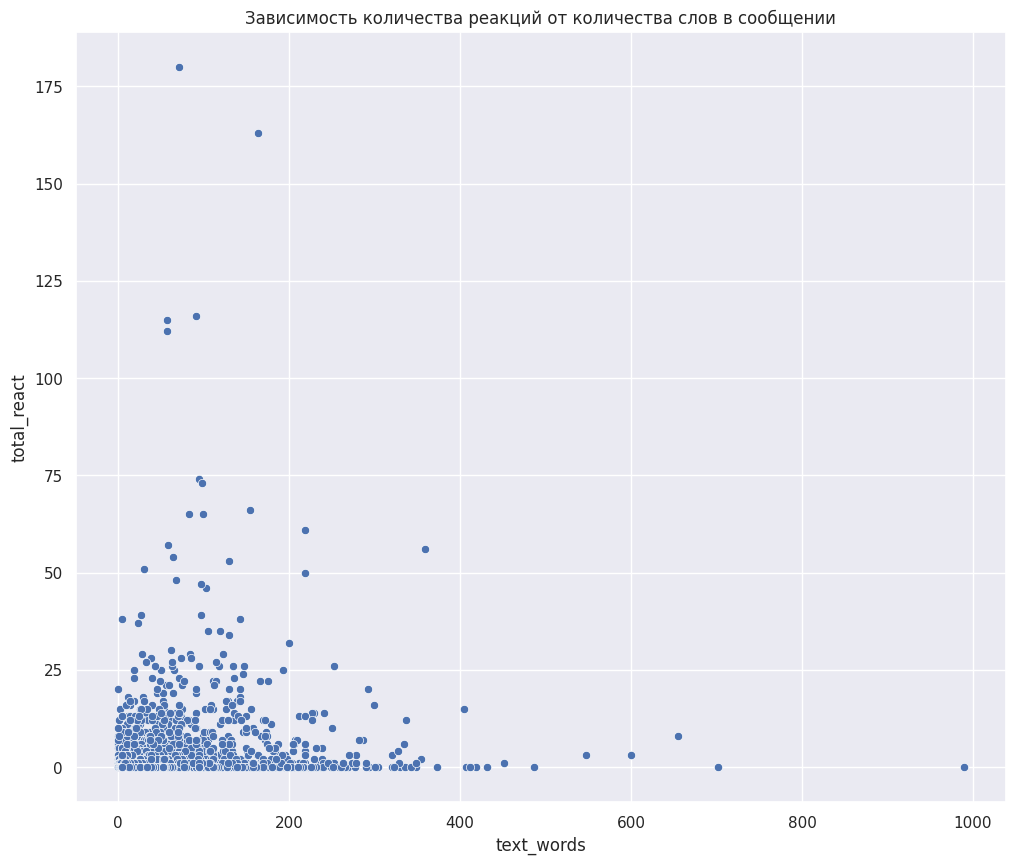

In [ ]:
fig = plt.gcf()
fig.set_size_inches(12, 10)
sns.set(color_codes=True)
sns.scatterplot(data=data, x="text_words", y="total_react").set(title='Зависимость количества реакций от количества слов в сообщении')
plt.show()


Какой-то определенной зависимости количества реакций от количества слов в сообщении не наблюдается. Но высокое количество реакций находится в пределах до 250 слов в сообщении

## Когорты

- Актиность по направлениям
- Активность когорт по постам и реакциям (выбор 12 активных для анализа)
- Анализ поведения 12 активных когорт во время спринта


### Активность по направлениям

In [ ]:
fig = px.bar(post_and_react, x=['total_msg', 'total_react'], y=post_and_react.index, text_auto=True,
              title="Абсолютное распределение количества сообщений и реакций по направлениям обучения")
fig.update_layout(
    xaxis_title="Количество",
    yaxis_title="Направление",
    legend_title="",
)

fig.show()

In [ ]:
fig = px.bar(post_and_react, x=['perc_of_total_msg', 'perc_of_total_react'], y=post_and_react.index, text_auto=True,
              title="Относительное распределение количества сообщений и реакций по направлениям обучения, %")
fig.update_layout(
    xaxis_title="Количество",
    yaxis_title="Направление",
    legend_title="",
)

fig.show()

В направлении Data Analysis больше всего сообщений(48,56% от общего количества) и реакций (53,54% от общего количества), а направление Data Lens оставляет практически равное количество сообщений и реакций

### Активность когорт

В списке представлены 87 когорт, многи из них либо уже закончили обучение, либо только начали - об этом можно судить о низкой активности.

In [ ]:
# график распределения сообщени и реакций по датам
df = post_and_react
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от дня недели')
fig.update_layout(
    xaxis_title="День недели",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()


В целом картина похожа: топ-12 когорт активизируются в среду и низкоактивны в выходные

In [ ]:
# создание сводной таблицы по количеству сообщения и реакций vs время
post_and_react = df_top_12.pivot_table(index='ts_time', values=['total_react'], aggfunc=['count','sum'])
post_and_react.columns = ['total_msg', 'total_react']
# график распределения сообщени и реакций по датам
df = post_and_react
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от времени суток')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

И здесь тоже всё совпадает с общей картиной: 07.00 и 13.00 - пики активности, с сохраняющейся активностью до 22.00

### Поведение топ-12 когорт только во время спринта


In [ ]:
# график распределения сообщени и реакций по датам во время спринта
df = post_and_react
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от дня недели')
fig.update_layout(
    xaxis_title="День недели",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()


In [ ]:
# создание сводной таблицы по количеству сообщения и реакций vs время
post_and_react = df_top_12.pivot_table(index='ts_time', values=['total_react'], aggfunc=['count','sum'])
post_and_react.columns = ['total_msg', 'total_react']
# график распределения сообщени и реакций по датам
df = post_and_react
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от времени суток')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

Во время спринта поведение пользователей в целом схоже с общей картиной: всплески реакций на сообщения в 07.00,10.00, 13.00, 17.00, 19.00, количество сообщений распределено нормально с 07.00 до 19.00 - высокая активность по сообщениям.

## Команда Практикума
- Определение пользователей, относящихся к команде
- Изучение юзеров с высокими показателями реакций
- Изучение юзеров с низкими показателями реакций


Построим сводную таблицу, в коротой посчитаем количество активностей каждого пользователя в различных когортах

In [ ]:
# построение сводной таблицы количества постов по когортам и пользователям
df_plot = data.groupby(['user', 'chogort_name']).size().reset_index().\
                        pivot(columns='chogort_name', index='user', values=0).convert_dtypes('Int64')
#df_plot = df_plot.fillna(0)
df_plot['total'] = df_plot.count(axis=1)
df_plot = df_plot.sort_values(by='total', ascending=False)
df_plot[:25] 

chogort_name,da_50,da_52,da_53,da_54,da_55,da_56,da_58,da_59,da_60,da_61,...,ds_plus_11,ds_plus_12,ds_plus_13,ds_plus_14,ds_plus_15,ds_plus_17,ds_plus_18,ds_plus_19,sql,total
user,,,,,,,,,,,,,,,,,,,,,
UUMQAGFHC,<NA>,<NA>,<NA>,<NA>,2,<NA>,<NA>,6,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,17,12
U02PLR8QYT0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,11,54,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,11
U02PET35SP5,<NA>,<NA>,<NA>,<NA>,<NA>,6,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,10
U02PMTEV3AN,<NA>,<NA>,24,19,<NA>,22,<NA>,31,2,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,9
USWN6S8V6,<NA>,<NA>,5,<NA>,<NA>,<NA>,<NA>,21,76,<NA>,...,15,<NA>,<NA>,<NA>,23,<NA>,<NA>,<NA>,<NA>,8
U031P6LDU56,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,11,<NA>,<NA>,<NA>,<NA>,<NA>,9,<NA>,7,7
U02PM7W18Q2,<NA>,<NA>,11,<NA>,<NA>,6,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,7
USWMKAJHW,<NA>,<NA>,30,<NA>,<NA>,<NA>,<NA>,81,<NA>,36,...,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,7
UU59EH1B8,<NA>,<NA>,<NA>,10,<NA>,4,<NA>,91,<NA>,3,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6


Отберем 24 возможных участника команды Практикума

In [ ]:
# сохраним их id в список
team_pr = df_plot[:24] 
team_pr_list = team_pr.index.to_list()
team_pr_list

['UUMQAGFHC',
 'U02PLR8QYT0',
 'U02PET35SP5',
 'U02PMTEV3AN',
 'USWN6S8V6',
 'U031P6LDU56',
 'U02PM7W18Q2',
 'USWMKAJHW',
 'UU59EH1B8',
 'U015F6ARVCN',
 'USB5VHPL3',
 'U031KRDA3FW',
 'U0125S9UD16',
 'U02M2SMQ8CR',
 'U01123SAR55',
 'U0313P05JJW',
 'U0179RY000Y',
 'U03QRHJDYBX',
 'U02APGPE54P',
 'U0185Q2MK19',
 'U03GJN2337H',
 'U03A3EWK561',
 'U02P54NFA9Z',
 'U02ML32S2DT']

In [ ]:
team_pr = data.query('user in @team_pr_list')
stud = data.query('user not in @team_pr_list')

In [ ]:
team_pr['team'].value_counts()

TPV9DP0N4    2311
0             152
Name: team, dtype: int64

Получается, что большинство из предполагаемых учатников команды Практикума действительно имеют в поле 'team' метку TPV9DP0N4, но не все.
Точно об этом факте судить нельзя, потому что TPV9DP0N4 нагенерировали 15703 активностей, а студенты всего лишь 2451 в общем датафрейме.
Оставим для анализа только выбранных 24 users

Таким образом, проанализировав реакции на сообщения пользователей - студентов и команды, видно, что 75% сообщений команды имеют как минимум 1 реакцию, а у сообщения студентов - нет.

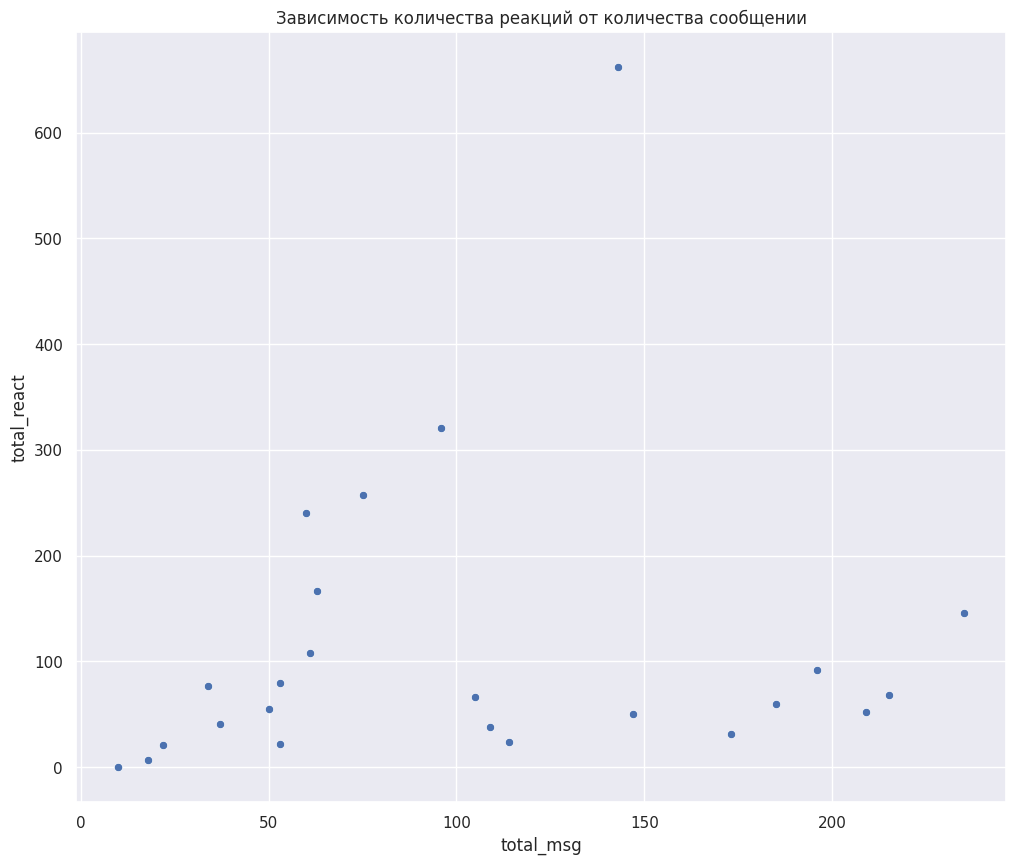

In [ ]:
fig = plt.gcf()
fig.set_size_inches(12, 10)
sns.set(color_codes=True)
sns.scatterplot(data=post_and_react, x="total_msg", y="total_react").set(title='Зависимость количества реакций от количества сообщении')
plt.show()

Таким образом, можно отобрать 10 предполагаемых участников команды Практикума, у которых количество реакций превышает количество сообщений. 

In [ ]:
post_and_react = post_and_react[:10]
post_and_react

,total_msg,total_react,perc
user,,,
U02PLR8QYT0,143,662,4.629371
UUMQAGFHC,60,240,4.000000
U03A3EWK561,75,257,3.426667
U031KRDA3FW,96,321,3.343750
U02PM7W18Q2,63,166,2.634921
U03QRHJDYBX,34,77,2.264706
U02M2SMQ8CR,61,108,1.770492
U02P54NFA9Z,53,79,1.490566
USB5VHPL3,37,41,1.108108


## Молодцы (соотношение реакций к сообщениям >2)

#### User U02PLR8QYT0 (4.6)

In [ ]:
# топчик
top = data.query('user=="U02PLR8QYT0"')


In [ ]:
post_and_react = top .pivot_table(index='ts_day', values=['total_react'], aggfunc=['count','sum'])
post_and_react.columns = ['total_msg', 'total_react']
post_and_react= post_and_react.reindex(cats) 
df = post_and_react.fillna(0)
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от дня недели')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

User U02PLR8QYT0 больше всего пишет сообщений в понедельник, но  большинство реакций получают сообщения, написанные в среду (возможно, именно в этот день он публикует анонсы)

In [ ]:
post_and_react = top.pivot_table(index='ts_time', values=['total_react'], aggfunc=['count','sum'])
post_and_react.columns = ['total_msg', 'total_react']
df = post_and_react.fillna(0)
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от времени суток')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

Всплески реакции на сообщения, написанные в 07.00, 09.00, 13.00, 15.00, 17.00 и ничего после 18.00

#### User UUMQAGFHC (4)

In [ ]:
# топчик
top = data.query('user=="UUMQAGFHC"')


In [ ]:
post_and_react = top .pivot_table(index='ts_day', values=['total_react'], aggfunc=['count','sum']).fillna(0)
post_and_react.columns = ['total_msg', 'total_react']
post_and_react= post_and_react.reindex(cats) 
df = post_and_react
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от дня недели')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

In [ ]:
post_and_react

,total_msg,total_react
ts_day,,
Monday,NaN,NaN
Tuesday,5.0,6.0
Wednesday,3.0,8.0
Thursday,14.0,129.0
Friday,1.0,1.0
Saturday,13.0,62.0
Sunday,24.0,34.0


User UUMQAGFHC  пишет большинство сообщений в четверг, субботу и воскресенье и всегда получает много реакций на сообщения, написанные в эти дни. В понедельник - выходной.

In [ ]:
post_and_react = top.pivot_table(index='ts_time', values=['total_react'], aggfunc=['count','sum']).fillna(0)
post_and_react.columns = ['total_msg', 'total_react']
df = post_and_react
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от времени суток')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

Всплески реакции совпадают с сообщениями. На сообщения этого пользователя всегда есть реакция с пиками в 12.00, 16.00. После 17.00 пользователь ничего не публикует

#### User U03A3EWK561 (3.43)

In [ ]:
# топчик
top = data.query('user=="U03A3EWK561"')


In [ ]:
post_and_react = top .pivot_table(index='ts_day', values=['total_react'], aggfunc=['count','sum']).fillna(0)
post_and_react.columns = ['total_msg', 'total_react']
post_and_react= post_and_react.reindex(cats) 
df = post_and_react.fillna(0)
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от дня недели')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

In [ ]:
post_and_react

,total_msg,total_react
ts_day,,
Monday,20.0,99.0
Tuesday,29.0,33.0
Wednesday,14.0,100.0
Thursday,5.0,17.0
Friday,6.0,7.0
Saturday,NaN,NaN
Sunday,1.0,1.0


User U03A3EWK561  пишет большинство сообщений в понедельник, вторник, среду (выходной СБ  ВСК), большинство реакций получают сообщения, написанные в ПН и СР.

In [ ]:
post_and_react = top.pivot_table(index='ts_time', values=['total_react'], aggfunc=['count','sum']).fillna(0)
post_and_react.columns = ['total_msg', 'total_react']
df = post_and_react
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от времени суток')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

Всплески реакции на сообщения, наприсанные в 07.00, 11.00, 13.00. После 15.00 сообщений нет.


#### User U031KRDA3FW (3.43)

In [ ]:
# топчик
top = data.query('user=="U031KRDA3FW"')


In [ ]:
post_and_react = top .pivot_table(index='ts_day', values=['total_react'], aggfunc=['count','sum']).fillna(0)
post_and_react.columns = ['total_msg', 'total_react']
post_and_react= post_and_react.reindex(cats) 
df = post_and_react.fillna(0)
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от дня недели')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

In [ ]:
post_and_react

,total_msg,total_react
ts_day,,
Monday,35.0,53.0
Tuesday,13.0,2.0
Wednesday,21.0,217.0
Thursday,6.0,0.0
Friday,19.0,48.0
Saturday,NaN,NaN
Sunday,2.0,1.0


User U031KRDA3FW  пишет большинство сообщений в понедельник, среду, пятницу (выходной СБ, ВСК), большинство реакций получают сообщения, написанные в ПН, СР (пик), ПТ.

In [ ]:
post_and_react = top.pivot_table(index='ts_time', values=['total_react'], aggfunc=['count','sum']).fillna(0)
post_and_react.columns = ['total_msg', 'total_react']
df = post_and_react.fillna(0)
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от времени суток')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

Всплески реакции на сообщения, наприсанные в 07.00, 11.00. После 16.00 сообщений нет.


#### User U02PM7W18Q2 (2.63)

In [ ]:
# топчик
top = data.query('user=="U02PM7W18Q2"')


In [ ]:
post_and_react = top .pivot_table(index='ts_day', values=['total_react'], aggfunc=['count','sum']).fillna(0)
post_and_react.columns = ['total_msg', 'total_react']
post_and_react= post_and_react.reindex(cats) 
df = post_and_react.fillna(0)
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от дня недели')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

In [ ]:
post_and_react

,total_msg,total_react
ts_day,,
Monday,35.0,71.0
Tuesday,2.0,0.0
Wednesday,9.0,10.0
Thursday,5.0,14.0
Friday,12.0,71.0
Saturday,NaN,NaN
Sunday,NaN,NaN


User U02PM7W18Q2  пишет большинство сообщений в понедельник (выходной СБ, ВСК), большинство реакций получают сообщения, написанные в ПН и ПТ. (скорее всего, это куратор с пожеланиями хорошей недели и отчетом о неделе в пятницу))) )

In [ ]:
post_and_react = top.pivot_table(index='ts_time', values=['total_react'], aggfunc=['count','sum']).fillna(0)
post_and_react.columns = ['total_msg', 'total_react']
df = post_and_react.fillna(0)
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от времени суток')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

Всплески реакции на сообщения, наприсанные в 07.00, 09.00, 11.00, 13.00. После 16.00 сообщений нет.


## Проблемные (соотношение реакций к сообщениям меньше 0.6)

### User U0179RY000Y (0.62)

In [ ]:
# топчик
top = data.query('user=="U0179RY000Y"')


In [ ]:
post_and_react = top .pivot_table(index='ts_day', values=['total_react'], aggfunc=['count','sum']).fillna(0)
post_and_react.columns = ['total_msg', 'total_react']
post_and_react= post_and_react.reindex(cats) 
df = post_and_react.fillna(0)
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от дня недели')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

In [ ]:
post_and_react

,total_msg,total_react
ts_day,,
Monday,55,25
Tuesday,29,10
Wednesday,32,25
Thursday,56,7
Friday,21,20
Saturday,15,3
Sunday,27,56


User U0179RY000Y пишет много сообщений каждый день, большинство реакций получают сообщения, написанные в воскресенье. (скорее всего, может быть наставник проекта или тренажера, которому оставляют реакции редко и под самый дедлайн)

In [ ]:
post_and_react = top.pivot_table(index='ts_time', values=['total_react'], aggfunc=['count','sum']).fillna(0)
post_and_react.columns = ['total_msg', 'total_react']
df = post_and_react.fillna(0)
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от времени суток')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

Всплески реакции на сообщения, наприсанные в 08.00, 11.00, 14.00, 20.00. 


### User U031P6LDU56 (0.41)

In [ ]:
# топчик
top = data.query('user=="U031P6LDU56"')


In [ ]:
post_and_react = top .pivot_table(index='ts_day', values=['total_react'], aggfunc=['count','sum']).fillna(0)
post_and_react.columns = ['total_msg', 'total_react']
post_and_react= post_and_react.reindex(cats) 
df = post_and_react.fillna(0)
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от дня недели')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

In [ ]:
post_and_react

,total_msg,total_react
ts_day,,
Monday,26.0,1.0
Tuesday,3.0,1.0
Wednesday,9.0,9.0
Thursday,14.0,11.0
Friday,NaN,NaN
Saturday,NaN,NaN
Sunday,1.0,0.0


User U031P6LDU56 в основном пишет сообщения в ПН и ЧТ, большинство реакций получают сообщения, написанные в четверг.

In [ ]:
post_and_react = top.pivot_table(index='ts_time', values=['total_react'], aggfunc=['count','sum']).fillna(0)
post_and_react.columns = ['total_msg', 'total_react']
df = post_and_react.fillna(0)
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от времени суток')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

Всплески реакции на сообщения, написанные в 08.00, 10.00, 13.00, 17.00. 


### User UU59EH1B8 (0.47)

In [ ]:
# топчик
top = data.query('user=="UU59EH1B8"')


In [ ]:
post_and_react = top .pivot_table(index='ts_day', values=['total_react'], aggfunc=['count','sum']).fillna(0)
post_and_react.columns = ['total_msg', 'total_react']
post_and_react= post_and_react.reindex(cats) 
df = post_and_react.fillna(0)
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от дня недели')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

In [ ]:
post_and_react

,total_msg,total_react
ts_day,,
Monday,25,16
Tuesday,34,21
Wednesday,31,14
Thursday,47,12
Friday,27,15
Saturday,19,9
Sunday,13,5


User UU59EH1B8 пишет сообщения каждый день, большинство реакций получают сообщения, написанные во вторник.

In [ ]:
post_and_react = top.pivot_table(index='ts_time', values=['total_react'], aggfunc=['count','sum']).fillna(0)
post_and_react.columns = ['total_msg', 'total_react']
df = post_and_react.fillna(0)
fig = px.line(df, x=df.index, y=['total_msg', 'total_react'],              
              title='График зависимости количества сообщений и количества реакций от времени суток')
fig.update_layout(
    xaxis_title="Время суток",
    yaxis_title="Количество",
    legend_title="",
)

fig.show()

Всплески реакции на сообщения, наприсанные в 04.00, 07.00, 09.00, 12.00, 13.00, 15.00, 18.00 (человек на связи 20 часов в сутки, готов общаться всегда)  ) 


## Активность студентов и команды по постам

In [ ]:
# временной промежуток в датасете (дней)
data_days = data['ts_date'].max() - data['ts_date'].min()
data_days = data_days.days
data_days

65

В датасете представлена инфорамция за 65 дней. 

Для команды главной активностью примем сообщения:
*    меньше 1 сообщения в день - "низкая активность"
* 1-2 сообщения в день - "средняя активность"
* более 2х сообщений в день - "высокая активность"



Text(0, 0.5, '')

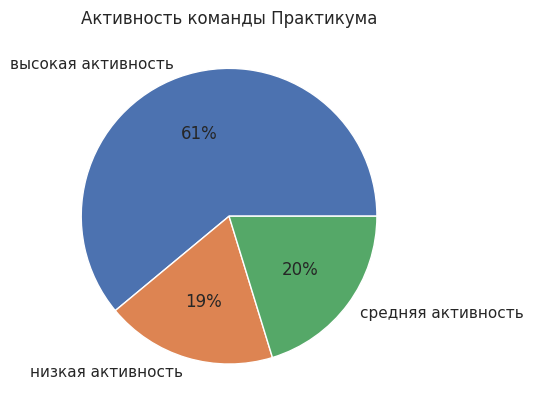

In [ ]:
# количество сообщений, написанных участниками команды Практикума
team_pr_df = team_pr.groupby('user').agg(msg=('ts', 'count'))
team_pr_df['cat'] = team_pr_df['msg'].apply(team_gr_activity)
ax = team_pr_df.groupby(['cat']).sum().plot(
    kind='pie', y='msg', autopct='%1.0f%%', legend=False, title = 'Активность команды Практикума')
ax.set_ylabel('')

Таким образом, 19% команды Практикума публикуют менее 1 сообщения в день

Для студентов  активностью примем сообщения:

* меньше 0.5 сообщения в день - "низкая активность"
* 0.5-1 сообщения в день - "средняя активность"
* более одного сообщений в день - "высокая активность"

Text(0, 0.5, '')

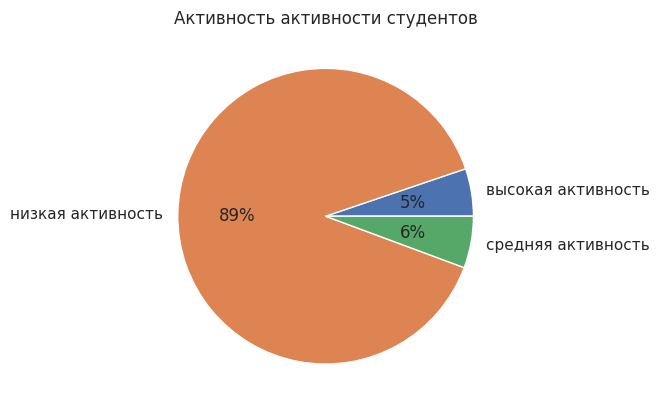

In [ ]:
stud_df = stud.groupby('user').agg(msg=('ts', 'count'))
stud_df['cat'] = stud_df['msg'].apply(st_gr_activity)
ax = stud_df.groupby(['cat']).sum().plot(
    kind='pie', y='msg', autopct='%1.0f%%', legend=False, title = 'Активность активности студентов')
ax.set_ylabel('')

89% студентов пишут менее трех сообщений в неделю

## Вывод по разделу
* Гипотеза 1. "Зависимость количества реакций от дня недели и времени суток" - подтверждается: больше всего реакций наблюдается в понедельник и среду, пики реакций на сообщения 07.00, 10.00, 13.00, 17.00
* Гипотеза 2. "Зависимость количества реакций от автора сообщения из команды Практикума" - вероятность такой зависимости высока (есть сообщения от команды в "правильные" часы и дни, но реакция все равно низкая). 
* Гипотеза 3. "Зависимость количества реакций от длины сообщения" - не подтверждается, зависимости нет, однако больше реакций получают сообщения до 220 символов (оценить этот параметр сложно, так как сообщения могут быть фрагментом кода)
* Гипотеза 4. "Кому больше отправляют реакций: студенту или команде?" - 75% сообщений от команды получают как минимум 1 реакцию, а у студентов - 0.

# Общий вывод
- Рассматриваемый временной период данных характеризуется активностью пользователей с 28.11 по 17.12 (совпадает с начало нового спринта и большим учебным проектом), в это время в большинстве каналов и когорт наблюдается рост числа сообщений и реакций на сообщения
- Количество постов и реакций на посты в целом совпадают по появлению: больше всего постов и реакций в понедельник и среду, меньше всего - в субботу. Несмотря на выходные и, казалось бы, свободное время, постить и оставлять реакции особо никому не хочется. Активность в понедельник чаще всего связана с началом спринтов. Команде не стоит публиковать анонсы в субботу и воскресенье.
- Пиковые моменты реакций на сообщения, опубликованные в 7.00  и 13.00. Возможно, это связано с тем, что утро многие начинают с телефона и просматривают сообщения и соцсети, аналогично в 13.00 - во время обеда - все занимаются тем же. Распределение количества сообщений близко к нормальному, активность сообщений наблюдается с 07.00 до 18.00. Утверждение о том, что в вечернее время студенты больше пишут сообщения и оставляют больше реакций на предоставленных данных не подтверждается.
- Самые популярные каналы: projects, exerciser, teamwork, info. В каналах projects и exerciser доля реакции / сообщения составляет менее 21-29% (понятно, что в этих каналах чаще спрашивают и отвечают сообщениями), а в каналах информационного характера info, digital_professions, tutorial, masterskaya, library, data_edteam_info - студенты получают информацию и оставляют реакцию о просмотре (чаще всего информация в комментариях-сообщения не нуждается, но бывает очень полезной на всем протяжении обучения, а не только в конкретный день).
- Зависимости количества реакций от количества слов в сообщении не наблюдается. Но высокое количество реакций находится в пределах до 250 слов в сообщении.
- В направлении Data Analysis больше всего сообщений(48,56% от общего количества) и реакций (53,54% от общего количества), а направление Data Lens оставляет практически равное количество сообщений и реакций.
- В списке представлены 87 когорт, многие из них либо уже закончили обучение, либо только начали - об этом можно судить о низкой активности.
-  Были отобраны топ-12 когорт по активности; участники активизируются в среду и низкоактивны в выходные; 07.00 и 13.00 - пики реакций на сообщения, написанные в это время, с сохраняющейся активностью до 22.00
- Во время спринта поведение пользователей в целом схоже с общей картиной: всплески реакций на сообщения, написанные в 07.00,10.00, 13.00, 17.00, 19.00, количество сообщений распределено нормально с 07.00 до 19.00 - высокая активность по сообщениям.
- Для определения возможных участником команды Практикума была построена сводная таблица по активностям в различных когортах (обычно студенты находятся в пределах 1-2 когорт, редко трёх). Был составлен список из 24 таких кандидатов.
- Проанализировав реакции на сообщения пользователей-студентов и команды, узнали, что 75% сообщений команды имеют как минимум 1 реакцию, а сообщения студентов - нет.
- Среди 24 возможных участников команды Практикума были отобраны 5 предполагаемых участников , у которых количество реакций превышает количество сообщений и 3 "проблемных" участника команды с низкой долей реакций. Поведение "успешных" в целом совпало с общей картиной откликов, но среди "неуспешных" сообщения, написанные в правильные дни и часы не получали должного количества реакций.
- 19% команды и 89 % студентов являются низкоактивными по написанию сообщений

## Рекомендации
Несмотря на наличие определенных дней и часов, необходим дополнительный анализ содержания сообщений и личности публикующего из команды Практикума. Возможно, кого-то студенты знают лучше, чем куратора, публикующего анонсы раз в неделю и не отвечающего на прямые вопросы.
Одно понятно точно, выходные - не очень удобное время для проведения встреч, игр, вебинаров: студенты загружены и делами, и учебой, выходные у кого-то - редкая возможность закончить дела.
Для того, чтобы повысить активность студентов и преподователей по сообщениям и реакциям, можно ввести достижение или бонус "поставь 100 реакций и получи скидку 2% на обучение". Или, если всё же важно, чтобы сообщение было просмотрено, а не просто проставлена реакция, можно заменить реакции на "глазик" с количеством просмотров (так команде будет ясно, сколько человек прочитало сообщение)



